In [45]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [46]:
outdict = readinput("Ag_C2_042925.rms")

[12:12:02] WARNING: not removing hydrogen atom without neighbors
[12:12:02] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [47]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [48]:
sitedensity = 2.292e-5; # Ag111
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,sitedensity,name="surface");

In [ ]:
# Reservoir is a 100 mL (100e-6 m^3) cell
# Proton concentration is 10^-7 mol/L (10^-4 mol/m^3)
# CO2 concentration is 0.01 mol/L (10 mol/m^3), saturation solubility ~0.03 mol/L
# Solvent concentration (water) is 55.6 mol/L (5.56e4 mol/m^3)
# AVratio in experiments is 36 m^-1 but is measured by surface area/reservoir volume
# Area of the electrode is therefore 3.6e1 m^-1 * 1e2*1e-6 m^3 = 3.6e-3 m^2 = 36 cm^2
# Assume boundary layer thickness d_bl = 1 mm or 1e-3 m
# Volume of the boundary layer V_bl = 3.6e-3 m^2 * 1e-3 m = 3.6e-6 m^3
# Actual AVratio is therefore 3.6e-3 m^2 / 3.6e-6 m^3 = 1e3 m^-1 (reciprocal of d_bl)
# Amount of sites is 2.292e-5 mol/m^2 * 1e3 m^-1 = 2.292e-2 mol/m^-3

C_proton = 1.0e-7*1.0e3;
C_co2 = 1.0e-2*1.0e3;
C_h2o = 5.56e4;
C_default = 1e-12;
V_res = 1.0e3;
AVratio = 1.0e3;
A_surf = V_res*36;
V_bl = A_surf/AVratio;
sites = sitedensity*A_surf;

initialcondsliq = Dict(["proton"=>C_proton * V_res,
                        "CO2"=>C_co2 * V_res,
                        "H2O"=>C_h2o * V_res,
                        "V"=>V_res,"T"=>300,"Phi"=>0.0,"d"=>0.0]);

initialcondssurf = Dict(["CO2X"=>0.4*sites,
        "CHO2X"=>0.1*sites,
        "CO2HX"=>0.1*sites,
        "OX"=>0.1*sites,
        "OCX"=>0.1*sites,
        "vacantX"=>0.1*sites,
        "CH2O2X"=>0.05*sites,
        "CHOX"=>0.04*sites,
        "CH2OX"=>0.01*sites,
        "A"=>A_surf,"T"=>300,"Phi"=>-1.414]);

In [50]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton","CO2","H2O"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [51]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,A_surf);

In [52]:
@time react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.8e3), [inter], (pliq,pcat,pinter));


  0.003065 seconds (8.83 k allocations: 7.948 MiB)


In [53]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-22,reltol=1e-8);
println(sol.t[end]);
println(sol.retcode);

  0.550028 seconds (1.50 M allocations: 876.191 MiB, 17.04% gc time)
1800.0
Success


In [54]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [55]:
# Helper function
function plotX(sim, tol, t_end, exclude)
    clf()
    xs = molefractions(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Mole Fraction")
end

plotX (generic function with 1 method)

In [56]:
# Helper function
function plotC(sim, tol, t_end, exclude)
    clf()
    xs = concentrations(sim)
    maxes = maximum(xs, dims=2)

    # Filter time data up to t_end
    time_indices = findall(t -> t <= t_end, sim.sol.t)
    time_filtered = sim.sol.t[time_indices]
    xs_filtered = xs[:, time_indices]

    for i = 1:length(maxes)
        species_name = sim.domain.phase.species[i].name
        if maxes[i] > tol && !(species_name in exclude)
            plot(time_filtered, xs_filtered[i,:], label=species_name)
        end
    end
    legend()
    xlabel("Time in Sec")
    ylabel("Concentration")
end

plotC (generic function with 1 method)

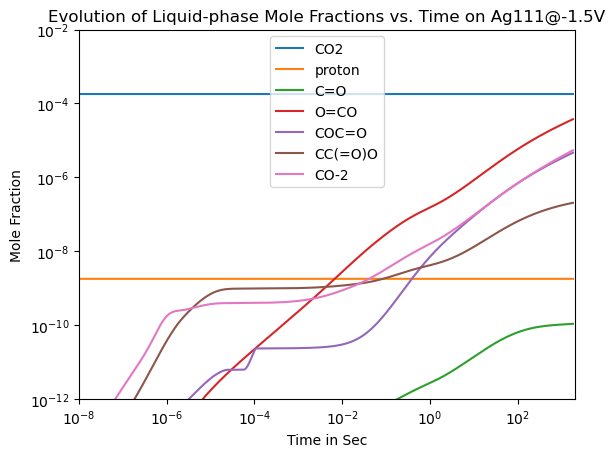

In [57]:
exclude_species = ["H2O"]
plotX(ssys.sims[1], 1e-10, 1.8e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 2e3)
ylim(1e-12, 1e-2)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

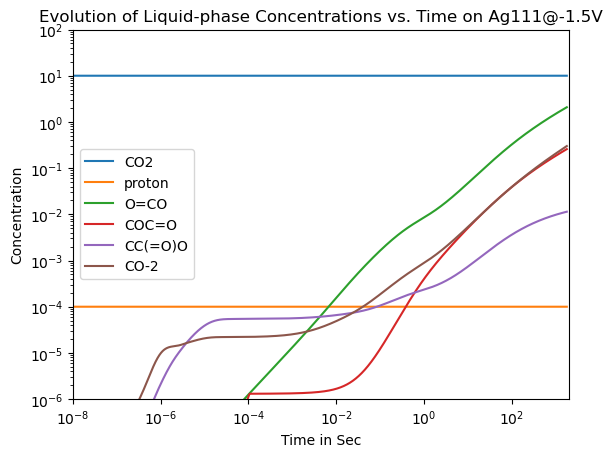

In [58]:
exclude_species = ["H2O"]
plotC(ssys.sims[1], 1e-5, 1.8e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-8, 2e3)
ylim(1e-6, 1e2)
title("Evolution of Liquid-phase Concentrations vs. Time on Ag111@-1.5V")
gcf()

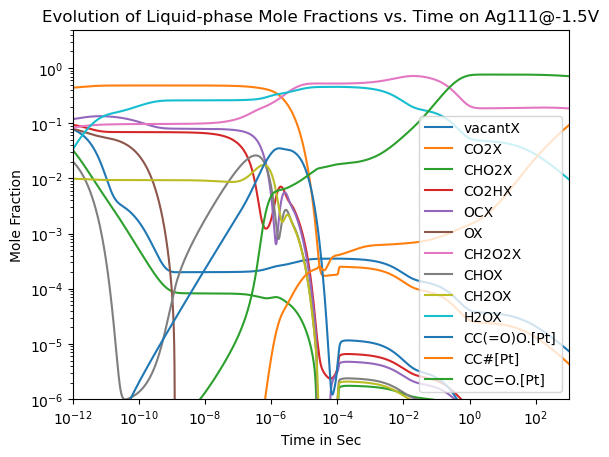

In [59]:
exclude_species = ["H2O"]
plotX(ssys.sims[2], 1e-2, 1e3, exclude_species)
xscale("log")
yscale("log")
xlim(1e-12, 1e3)
ylim(1e-6, 5)
title("Evolution of Liquid-phase Mole Fractions vs. Time on Ag111@-1.5V")
gcf()

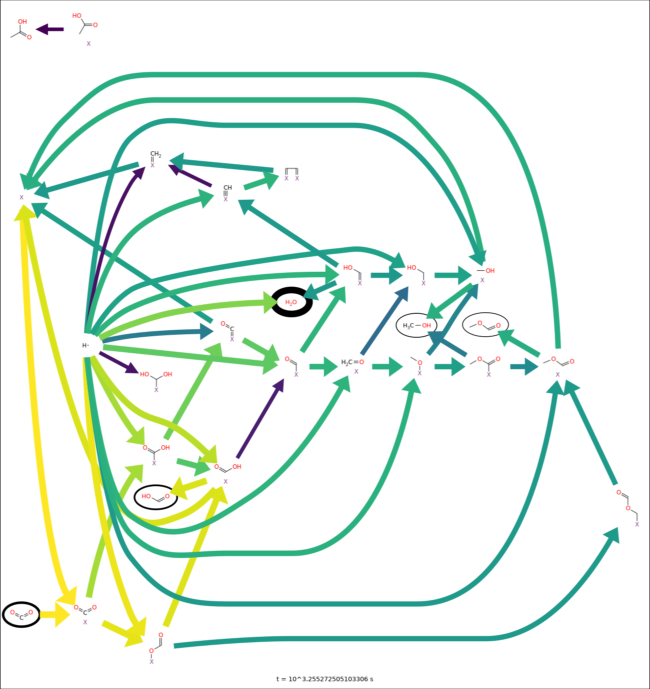

In [60]:
getfluxdiagram(ssys,1.8e3;speciesratetolerance=1e-6)

In [61]:
println(ssys.names)

["Ar", "He", "Ne", "N2", "CO2", "proton", "H", "C=O", "O=CO", "O2", "O=C=C=O", "H2O", "CO", "C=C=O", "O=C=CO", "H2", "O=CC=O", "O=CCO", "COC=O", "CC(=O)O", "CO-2", "CC=O", "OCO", "OCCO", "C=C", "vacantX", "CO2X", "CHO2X", "CO2HX", "OCX", "OX", "CH2O2X", "CHOX", "CH2OX", "HOX", "O=C([Pt])C(=O)[Pt]", "HX", "H2OX", "O=CC(=O)[Pt]", "CX", "O=O.[Pt]", "O=C=C=O.[Pt]", "OC#[Pt]", "O=C([Pt])C#[Pt]", "CH2X", "O=C([Pt])C[Pt]", "[Pt]CO[Pt]", "O=C([Pt])OC[Pt]", "C=C=O.[Pt]", "O=C(C[Pt])O[Pt]", "O=C([Pt])C=[Pt]", "[Pt]OC=[Pt]", "O=C=C=[Pt]", "CHX", "O=C([Pt])CO[Pt]", "[Pt]OCO[Pt]", "O=C=C[Pt]", "[Pt]COO[Pt]", "O=C=CO[Pt]", "OO[Pt]", "O=C([Pt])C(O)=[Pt]", "OC(=[Pt])O[Pt]", "OC=[Pt]", "OC([Pt])O[Pt]", "O=C([Pt])C(O)[Pt]", "O=C=CO.[Pt]", "O=C=C([Pt])O[Pt]", "CO[Pt]", "COC(=O)[Pt]", "CC(=O)[Pt]", "CC(=O)O[Pt]", "CH3X", "OC[Pt]", "O=C([Pt])CO", "OCO[Pt]", "O=C([Pt])OC=[Pt]", "COO[Pt]", "[H][H].[Pt]", "O=C(C=[Pt])O[Pt]", "CO.[Pt]", "O=C(C#[Pt])O[Pt]", "O=C=C(O)[Pt]", "OC(O)[Pt]", "OC(O)=[Pt]", "CC(=O)O.[P

In [62]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 20654.615923781494
krev = 11189.298480848476
Kc = 1.8459259049290524
proton+CO2X<=>CHO2X
kf = 2.901741644670854e9
krev = 1899.6670255179733
Kc = 1.5275001385464643e6
proton+CO2X<=>CO2HX
kf = 1.4635836812024672e9
krev = 3.811669269961144e-9
Kc = 3.839744682826029e17
proton+CHO2X<=>CH2O2X
kf = 2.5e10
krev = 9.141528182057173e-33
Kc = 2.734772513097925e42
proton+CO2HX<=>CH2O2X
kf = 2.5e10
krev = 2.2979463860055554e-21
Kc = 1.0879279060751577e31
proton+OCX<=>CHOX
kf = 2.5e10
krev = 2.6138381923072832e-17
Kc = 9.564478808817174e26
proton+CHOX<=>CH2OX
kf = 2.5e10
krev = 6.953217448005557e-17
Kc = 3.5954578131553956e26
vacantX+vacantX+CO2<=>OX+OCX
kf = 3.0109478093912387e-24
krev = 3.0371562968883405e15
Kc = 9.913707149270016e-40
OX+proton<=>HOX
kf = 2.5e10
krev = 4.7718507938688055e-21
Kc = 5.239057355297378e30
vacantX+C=O<=>CH2OX
kf = 500114.13488002896
krev = 399.68032800366484
Kc = 1251.2853394061547
proton+CHO2X<=>OX+C=O
kf = 4.478925490216818e-5
krev = 4.63526026

In [63]:
fieldnames(typeof(domaincat.phase.reactions[124]))

(:index, :reactants, :reactantinds, :products, :productinds, :kinetics, :electronchange, :radicalchange, :reversible, :forwardable, :pairs, :fragmentbasedreactants, :fragmentbasedproducts, :fragmentbasedreactantinds, :fragmentbasedproductinds, :comment)

In [64]:
r = domaincat.phase.reactions[124]

OX+CHX<=>[Pt]OC=[Pt]

In [65]:
r.reactants

2-element StaticArraysCore.SVector{2, Species{NASA{EmptyThermoUncertainty}, EmptyDiffusivity, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}} with indices SOneTo(2):
 Species{NASA{EmptyThermoUncertainty}, EmptyDiffusivity, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}("OX", 6, "", "O=[Pt]", "1 O u0 p2 c0 {2,D}\n\n2 X u0 p0 c0 {1,D}\n\n", NASA{EmptyThermoUncertainty}
  polys: Array{NASApolynomial}((2,))
  unc: EmptyThermoUncertainty EmptyThermoUncertainty()
, Dict("X" => 1, "O" => 1), 1, EmptyDiffusivity(), 0.0, 0, 0.01599939912557602, EmptyHenryLawConstant(), EmptyLiquidVolumetricMassTransferCoefficient(), "Thermo library corrected for liquid phase: surfaceThermoPt111 Binding\nenergy corrected by LSR (1.00O) from Pt111 + Solvation correction with water\nas solvent and solute estimated using Solute library: water", false, false)
 Species{NASA{EmptyThermoUncertainty}, EmptyDiffusivity, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCo